In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import datetime

import imageio
from skimage.measure import block_reduce

In [2]:
patch_size = 8
nb_channels = 3

batch_size = 32

In [3]:
base_dir = '/home/niaki/Code/ImageNet/tiny-imagenet-200'

train_data_dir      = base_dir + '/tiny_train16'
validation_data_dir = base_dir + '/tiny_validation16'
test_data_dir       = base_dir + '/tiny_test16'

In [8]:
def loading_data_cropped(dir_patches):
    """Load all the patches from dir_patches into tensors for training the autoencoder.
    Return:
        patches_in  -- tensor of stacked patches centre-cropped to 8x8    
    """
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        patch_in = patch_in[4: 12, 4: 12, :]  # center-crop to 8x8
#         patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
        patches_in.append(patch_in)
#         patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
#     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
#     patches_out = np.array(patches_out)
#     patches_out = patches_out.astype(np.float64) / 255
#     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
    print("in", patches_in.shape)# , "; out", patches_out.shape)
    
    return patches_in#, patches_out

In [10]:
x_train = loading_data_cropped(train_data_dir)  # y_train
x_validation = loading_data_cropped(validation_data_dir)  # y_validation

in (157086, 8, 8, 3)
in (3932, 8, 8, 3)


In [11]:
# def loading_data(dir_patches):
#     """Load all the patches from dir_patches into tensors for training the autoencoder.
#     Return:
#         patches_in  -- tensor of stacked patches in their original shape, 16x16
#         patches_out -- tensor of the original patches downsampled to 8x8
    
#     """
#     files_patches = listdir(dir_patches + '/class0')
#     files_patches.sort()
    
#     patches_in = []
#     patches_out = []

    
#     for file_patch in files_patches:
#         patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
#         patch_out = block_reduce(patch_in, (2, 2, 1), func=np.mean)  # downsample (mean-pool)
        
#         patches_in.append(patch_in)
#         patches_out.append(patch_out)
        

#     patches_in = np.array(patches_in)
#     patches_in = patches_in.astype(np.float64) / 255
# #     patches_in = np.expand_dims(patches_in, -1)  # need this if grayscale
    
#     patches_out = np.array(patches_out)
#     patches_out = patches_out.astype(np.float64) / 255
# #     patches_out = np.expand_dims(patches_out, -1)  # need this if grayscale
        
#     print("in", patches_in.shape, "; out", patches_out.shape)
    
#     return patches_in, patches_out

In [12]:
# x_train, _ = loading_data(train_data_dir)  # y_train
# x_validation, _ = loading_data(validation_data_dir)  # y_validation

In [13]:
y_train = x_train
y_validation = x_validation

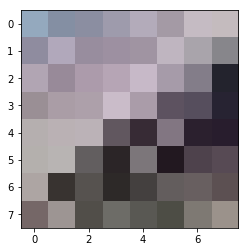

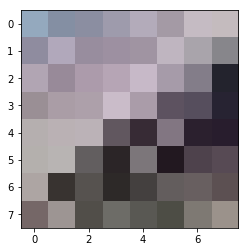

In [15]:
temp_index = np.random.randint(x_train.shape[0]) #  5429
# print(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.imshow(np.array(np.round(x_train[temp_index] * 255), dtype=np.uint8))
plt.show()
plt.imshow(np.array(np.round(y_train[temp_index] * 255), dtype=np.uint8))
plt.show()

In [16]:
input_shape = (patch_size, patch_size, nb_channels)
input_img = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation="elu", padding="same")(input_img)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
x = MaxPool2D((2, 2), padding="same")(x)
encoded = MaxPool2D((2, 2), padding="same")(x)


x = Conv2D(32, (3, 3), activation="elu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation="elu", padding="same")(x)  # decoded = Conv2D(3, (3, 3), activation="elu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation="elu", padding="same")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0     

In [15]:
# model_version_dwnsmpld_output = 'patch_desc_ae_20201026_14251116_alex_3conv3mp_2020_augm_elu_lastelu_dwnsmpl'
# autoencoder_dwnsmpld_output = load_model(base_dir + '/' + model_version_dwnsmpld_output + '.h5')

# for i in range(11):
#     print(autoencoder_dwnsmpld_output.get_layer(index=i))
#     autoencoder.get_layer(index=i).set_weights(autoencoder_dwnsmpld_output.get_layer(index=i).get_weights())

In [17]:
image_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
    width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
    horizontal_flip=False, fill_mode="nearest")

In [18]:
import wandb
from wandb.keras import WandbCallback
# os.environ['WANDB_MODE'] = 'dryrun'

In [19]:
run = wandb.init(
  project="patch-desc-ae",
  config={
    "augmentation": True,
    "elus": False,
    "last_layer_activation": "elu",
    "downsampling_output": False,
    "optimizer": "adadelta", 
    "loss": "binary_crossentropy",
    "epochs": 500,
    "patch_size": 8}
)

wandb: Currently logged in as: nimpy (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.8 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [20]:
%%wandb

model_version = 'patch_desc_ae_' + datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + '8_alex_3conv3mp_2020_augm_elu_lastelu_NOTdwnsmpl'

os.system('mkdir ' + base_dir + '/weights_' + model_version)
print(base_dir + '/weights_' + model_version)

# checkpointer = ModelCheckpoint(base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

history_callback = autoencoder.fit(image_datagen.flow(x_train, y_train, batch_size),
                epochs=wandb.config.epochs,
                validation_data=image_datagen.flow(x_validation, y_validation, batch_size),
                callbacks=[WandbCallback(data_type="image", predictions=1)]
                )
autoencoder.save(base_dir + '/' + model_version + '.h5')

# autoencoder = load_model(base_dir + '/' + model_version + '.h5')

/home/niaki/Code/ImageNet/tiny-imagenet-200/weights_patch_desc_ae_20201030_1404318_alex_3conv3mp_2020_augm_elu_lastelu_NOTdwnsmpl
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4909 steps, validate for 123 steps
Epoch 1/500
4909/4909 [==============================] - 47s 10ms/step - loss: 1.0684 - val_loss: 0.6186
Epoch 2/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5947 - val_loss: 0.5756
Epoch 3/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5748 - val_loss: 0.5660
Epoch 4/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5683 - val_loss: 0.5612
Epoch 5/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5641 - val_loss: 0.5574
Epoch 6/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5602 - val_loss: 0.5535
Epoch 7/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5563 - val_loss: 0.5492
Epoch 8/500
4909/4909 [=======================

Epoch 76/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5304 - val_loss: 0.5257
Epoch 77/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5303 - val_loss: 0.5255
Epoch 78/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5302 - val_loss: 0.5257
Epoch 79/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5302 - val_loss: 0.5254
Epoch 80/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5302 - val_loss: 0.5254
Epoch 81/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5301 - val_loss: 0.5254
Epoch 82/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5300 - val_loss: 0.5255
Epoch 83/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5301 - val_loss: 0.5255
Epoch 84/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5300 - val_loss: 0.5255
Epoch 85/500
4909/4909 [==============================]

4909/4909 [==============================] - 46s 9ms/step - loss: 0.5256 - val_loss: 0.5212
Epoch 231/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5256 - val_loss: 0.5212
Epoch 232/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5256 - val_loss: 0.5212
Epoch 233/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5256 - val_loss: 0.5211
Epoch 234/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5255 - val_loss: 0.5207
Epoch 235/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5255 - val_loss: 0.5209
Epoch 236/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5255 - val_loss: 0.5208
Epoch 237/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5255 - val_loss: 0.5208
Epoch 238/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5255 - val_loss: 0.5211
Epoch 239/500
4909/4909 [==============================] - 4

4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5193
Epoch 385/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5193
Epoch 386/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5194
Epoch 387/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5196
Epoch 388/500
4909/4909 [==============================] - 45s 9ms/step - loss: 0.5236 - val_loss: 0.5193
Epoch 389/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5194
Epoch 390/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5237 - val_loss: 0.5191
Epoch 391/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5236 - val_loss: 0.5193
Epoch 392/500
4909/4909 [==============================] - 46s 9ms/step - loss: 0.5236 - val_loss: 0.5190
Epoch 393/500
4909/4909 [==============================] - 4

In [21]:
history_callback.history

{'loss': [1.068377174709958,
  0.5947456061297459,
  0.574823867837119,
  0.568273215027032,
  0.5641010319071215,
  0.5602473130393757,
  0.5563150000089861,
  0.552475645503958,
  0.5498284583943623,
  0.5479230257507806,
  0.5464430404980078,
  0.5453583050992626,
  0.5442801084475997,
  0.5432381827760875,
  0.5422809018091335,
  0.5413961509396825,
  0.5405217153687601,
  0.5397875459051241,
  0.5391285980556586,
  0.5385475417734803,
  0.5380775990474974,
  0.5376462955244337,
  0.5372382814741851,
  0.5368034366241315,
  0.5363939960632192,
  0.5360575693829889,
  0.5357197200988045,
  0.535451823111219,
  0.53517677905068,
  0.534911313516432,
  0.5346473203041051,
  0.5344342031898147,
  0.534226682672629,
  0.5340069451179162,
  0.5338153242677852,
  0.5336572671996587,
  0.5334905259154775,
  0.5333664291201842,
  0.5331998471998648,
  0.5330723661587352,
  0.5329699229971285,
  0.53286920406434,
  0.5326796183193871,
  0.5326212196762442,
  0.5324641826843594,
  0.532332514

predictions: 


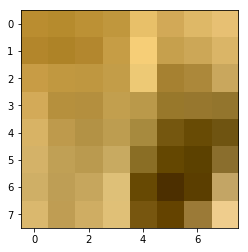

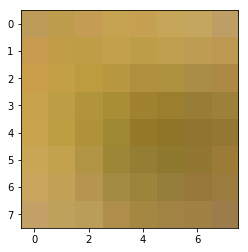

next


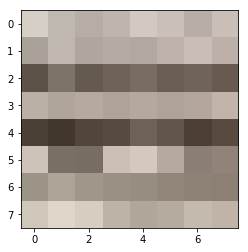

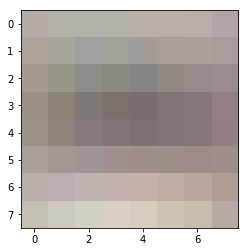

next


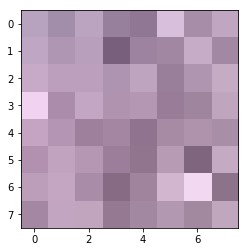

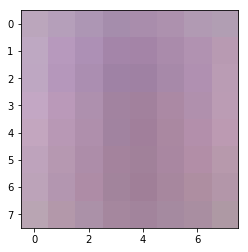

In [25]:
images_directory = base_dir + '/tiny_test16/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        img = imageio.imread(images_directory + '/' + file)
        img = img[4: 12, 4: 12, :]
        img = np.expand_dims(img, axis=-1)        
        images.append(img)


images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = autoencoder.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1, interpolation='nearest')
    plt.show()
    
    pred_1 = predictions[i].numpy()#.reshape(input_shape)
    plt.imshow(pred_1, interpolation='nearest')
    plt.show()
    
    if i == 2:
        break
    print("next")


In [26]:
encoder = Model(input_img, encoded)
for i in range(1, len(encoder.layers)):
    print(encoder.get_layer(index=i))
    encoder.get_layer(index=i).set_weights(autoencoder.get_layer(index=i).get_weights())
encoder.summary()

# encoder.save(base_dir + '/encoder' + model_version + '.h5')
encoder.save(base_dir + '/' + model_version + '__encoder.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 3)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0   

In [27]:
predictions = encoder.predict_on_batch(np.array(images))

In [33]:
predictions[12]

<tf.Tensor: shape=(1, 1, 32), dtype=float32, numpy=
array([[[ 0.23345804,  0.13077457,  0.23456451,  0.17916967,
          0.2824274 ,  0.05104627,  0.09579747,  0.07939498,
          0.0850114 ,  0.06821102,  0.03490557,  0.25148502,
          0.03727317,  0.12141401,  0.35879073,  0.09728938,
          0.10271734,  0.08301196, -0.03964257,  0.16273871,
          0.02464434,  0.1567319 ,  0.14562167,  0.18703483,
          0.15531506,  0.19795409, -0.04767317, -0.00051337,
          0.2275063 ,  0.01976364,  0.21862242,  0.16393398]]],
      dtype=float32)>

In [29]:
np.min(predictions.numpy())

-0.3005839

In [30]:
np.max(predictions.numpy())

1.157861

In [31]:
predictions.shape

TensorShape([100, 1, 1, 32])

In [34]:
run.finish()

epoch,499
loss,0.52295
val_loss,0.51856
_step,499
_runtime,22961
_timestamp,1604085961
best_val_loss,0.51832
best_epoch,490


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


(array([ 46., 136., 939., 769., 501., 345., 266., 145.,  37.,  16.]),
 array([-0.3005839 , -0.15473941, -0.00889492,  0.13694957,  0.28279406,
         0.42863855,  0.57448304,  0.7203275 ,  0.866172  ,  1.0120165 ,
         1.157861  ], dtype=float32),
 <a list of 10 Patch objects>)

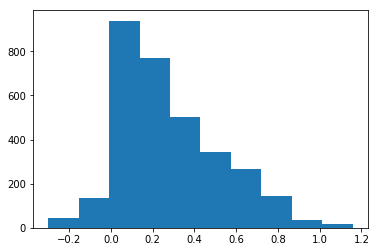

In [35]:
plt.hist(predictions.numpy().flatten())

In [36]:
np.argmin(history_callback.history["val_loss"])

490

In [37]:
# wandb run dreadful-bones-7